# <h1 style="text-align:center;font-size:30px;" > Emial Identifier </h1>

<h1> 1. Business Problem </h1>

<h2> 1.1 Description </h2>

<p>Fetch processes and rewards points to its customers for both physical and digital receipts. A customer can snap and upload the picture of physical (paper) receipts to get rewards. They can connect their email account or Amazon account to process digital receipts (eReceipts) and get points. In this exercise we will focus on eReceipt processing.</p>
<p>
When a customer places an order, they receive several emails from the retailers/stores regarding their purchases. Not all of these emails that end up in their inbox are actual eReceipts. Explain your approach on how you would identify which email is a genuine eReceipt and not a shipping update/ marketing email/ refund/ return/ cancellation type email.
</p>
<br>
> Credits: Fetch 


<h2>1.2 Import Libararies</h2>

In [2]:
from bs4 import BeautifulSoup
import re
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix


import warnings
warnings.filterwarnings("ignore")
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from subprocess import check_output
%matplotlib inline
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls
import os
import gc

import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
import re
from nltk.corpus import stopwords
# This package is used for finding longest common subsequence between two strings
# you can write your own dp code for this
from nltk.stem import PorterStemmer
from bs4 import BeautifulSoup
from fuzzywuzzy import fuzz
from sklearn.manifold import TSNE
# Import the Required lib packages for WORD-Cloud generation
# https://stackoverflow.com/questions/45625434/how-to-install-wordcloud-in-python3-6
from wordcloud import WordCloud, STOPWORDS
from os import path
from PIL import Image
from sklearn.preprocessing import StandardScaler
from collections import Counter
from sklearn.metrics import accuracy_score, log_loss
from sklearn.linear_model import SGDClassifier
from sklearn.calibration import CalibratedClassifierCV

<h2> 1.3 Parse HTML files - Create Word-based Features: </h2>

In [3]:

# Function to read HTML file and load its contents
def read_html_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        html_content = file.read()
    return html_content

# Function to preprocess HTML content
def preprocess_html_content(html_content):
    # Parse the HTML content using BeautifulSoup
    soup = BeautifulSoup(html_content, 'html.parser')

    # Remove unnecessary HTML tags, scripts, and styles
    for script in soup(["script", "style"]):
        script.extract()

    # Get the plain text content
    plain_text = soup.get_text()

    # Remove special characters, extra whitespaces, and newlines
    cleaned_text = re.sub(r'\s+', ' ', plain_text)
    cleaned_text = re.sub(r'[^\w\s]', '', cleaned_text)

    # Convert to lowercase
    cleaned_text = cleaned_text.lower()

    return cleaned_text

def extract_title_from_html_content(html_content):
    """
    Extract the subject from an HTML email file.
    """
    # Parse the HTML content
    soup = BeautifulSoup(html_content, "html.parser")

    # Find the element containing the email subject
    subject_tag = soup.find("title")  # You may need to adjust this based on the HTML structure
    # Extract the subject text
    subject = subject_tag.text.strip() if subject_tag else ""
    
    # Remove special characters, extra whitespaces, and newlines
    cleaned_subject = re.sub(r'\s+', ' ', subject)
    cleaned_subject = re.sub(r'[^\w\s]', '', cleaned_subject)
    return cleaned_subject

def extract_body_length_from_html_content(html_content):
    """
    Extract the body lenght from an HTML email file.
    """
    # Parse the HTML content
    soup = BeautifulSoup(html_content, "html.parser")

    # Find the element containing the email subject
    subject_tag = soup.find("body")  # You may need to adjust this based on the HTML structure
    # Extract the subject text
    subject = subject_tag.text.strip() if subject_tag else ""
    
    # Remove special characters, extra whitespaces, and newlines
    cleaned_subject = re.sub(r'\s+', ' ', subject)
    cleaned_subject = re.sub(r'[^\w\s]', '', cleaned_subject)
    return len(cleaned_subject)

def extract_specific_keyword_presence(texts, keywords):
    """
    Extract binary features indicating the presence of specific keywords in each email.

    Parameters:
        texts (list): A list of strings, where each string represents the email content.
        keywords (list): A list of strings containing the keywords to check for.

    Returns:
        keyword_presence (list of lists): A list of lists containing binary features for each keyword's presence in each email.
    """
    keyword_presence = []
    for text in texts:
        keyword_presence_per_email = []
        for keyword in keywords:
            # Use a case-insensitive regular expression to check for the presence of the keyword
            keyword_found = bool(re.search(re.escape(keyword), text, re.IGNORECASE))
            keyword_presence_per_email.append(int(keyword_found))
        keyword_presence.append(keyword_presence_per_email)
    return keyword_presence


# Set the directory containing HTML files (replace 'your_directory' with your actual directory path)
data_directory = '/Users/abhilash/Desktop/Email Identifier/Task 1 - Email_Identifier'

# Gather labeled data from HTML files
data = []
file_labels = {
    'eReceipt': 'eReceipt',
    'shipping_update': 'Shipping Update',
    # Add more file labels for other types of HTML files
}



for file_name in os.listdir(data_directory):
    label = None
    for key, value in file_labels.items():
        if key in file_name:
            label = value
            break
    if label:
        file_path = os.path.join(data_directory, file_name)
        html_content = read_html_file(file_path)
        cleaned_content = preprocess_html_content(html_content)
        html_title = extract_title_from_html_content(html_content)
        html_title_length = len(html_title) 
        html_body_lenght = extract_body_length_from_html_content(html_content)
        data.append({'filename': file_name, 'email_text': cleaned_content,'email_subject': html_title,'email_subject_length':html_title_length,'email_body_length':html_body_lenght, 'class_label': label})

# Create a DataFrame from the data
all_data = pd.DataFrame(data)

# Define the keywords to check for
keywords_to_check = ["Order", "shipping","delivery"]

#check for specific keywords 
keyword_presence_features = extract_specific_keyword_presence(all_data["email_text"], keywords_to_check)
# Create a new DataFrame with the binary features for each keyword
keyword_presence_df = pd.DataFrame(keyword_presence_features, columns=['order_keyword','shipping_keyword','delivery_keyword'])
# Concatenate the original DataFrame with the keyword presence DataFrame
all_data = pd.concat([all_data, keyword_presence_df], axis=1)

diction={'Shipping Update':0,'eReceipt':1}
all_data['class_label']=all_data['class_label'].map(diction)
data_df=all_data

KeyError: 'email_text'

In [145]:
data_df

,filename,email_text,email_subject,email_subject_length,email_body_length,class_label,order_keyword,shipping_keyword,delivery_keyword
0,shipping_update_walmart.html,gmail out for delivery items from order 20001...,Gmail Out for delivery items from order 20001...,56,1088,0,1,0,1
1,shipping_update_amazon.html,gmail your amazoncom order 11437432531977031 ...,Gmail Your Amazoncom order 11437432531977031 ...,57,1221,0,1,0,0
2,eReceipt_Nike.html,gmail your receipt from nike store allenabhil...,Gmail Your receipt from Nike Store Allen,41,1785,1,1,0,0
3,shipping_update.html,billing summary for your recent barnes noble ...,,0,0,0,1,0,0
4,eReceipt.html,barnes noble order confirmation 241300967 fin...,,0,0,1,1,1,1
5,eReceipt_apple.html,gmail were processing your order w1311414442a...,Gmail Were processing your order W1311414442,45,2861,1,1,1,1


<h2>1.4 Basic Feature Extraction - Word-based Features: </h2>

In [146]:
#Basic Feature Extraction
#Word-based Features:

#Word Count: Count the number of words in each document.
#Average Word Length: Compute the average length of words in each document.
#Stopword Count: Count the number of stopwords (commonly occurring words with little semantic meaning) in each document.
#Special Character Count: Count the occurrences of specific characters or symbols (e.g., question marks, exclamation marks) in each document.
#Vocabulary Size: Calculate the number of unique words in each document.
#text_length = Length of content
data_df['email_text_length'] = data_df['email_text'].str.len() 
#content_words = Number of words in Question 1
data_df['email_text_words'] = data_df['email_text'].apply(lambda row: len(row.split(" ")))

def extract_vocabulary_size(texts):
    """
    Extract the vocabulary size (number of unique words) in each document.

    Parameters:
        texts (list): A list of strings, where each string represents a document.

    Returns:
        vocabulary_sizes (list): A list of vocabulary sizes for each document.
    """
    vocabulary_sizes = []
    for doc in texts:
        # Tokenize words
        words = re.findall(r'\b\w+\b', doc)
        # Calculate vocabulary size
        vocabulary_size = len(set(words))
        vocabulary_sizes.append(vocabulary_size)

    return vocabulary_sizes
data_df["email_text_unique_words"] = extract_vocabulary_size(data_df["email_text"])

In [147]:
data_df

,filename,email_text,email_subject,email_subject_length,email_body_length,class_label,order_keyword,shipping_keyword,delivery_keyword,email_text_length,email_text_words,email_text_unique_words
0,shipping_update_walmart.html,gmail out for delivery items from order 20001...,Gmail Out for delivery items from order 20001...,56,1088,0,1,0,1,1145,253,111
1,shipping_update_amazon.html,gmail your amazoncom order 11437432531977031 ...,Gmail Your Amazoncom order 11437432531977031 ...,57,1221,0,1,0,0,1279,198,132
2,eReceipt_Nike.html,gmail your receipt from nike store allenabhil...,Gmail Your receipt from Nike Store Allen,41,1785,1,1,0,0,1827,290,200
3,shipping_update.html,billing summary for your recent barnes noble ...,,0,0,0,1,0,0,1007,178,126
4,eReceipt.html,barnes noble order confirmation 241300967 fin...,,0,0,1,1,1,1,2723,486,259
5,eReceipt_apple.html,gmail were processing your order w1311414442a...,Gmail Were processing your order W1311414442,45,2861,1,1,1,1,2907,495,280


<h2> 1.5 Text column Preprocessing </h2>

In [148]:
def preprocess(x):
    x = str(x).lower()
    x = x.replace(",000,000", "m").replace(",000", "k").replace("′", "'").replace("’", "'")\
                           .replace("won't", "will not").replace("cannot", "can not").replace("can't", "can not")\
                           .replace("n't", " not").replace("what's", "what is").replace("it's", "it is")\
                           .replace("'ve", " have").replace("i'm", "i am").replace("'re", " are")\
                           .replace("he's", "he is").replace("she's", "she is").replace("'s", " own")\
                           .replace("%", " percent ").replace("₹", " rupee ").replace("$", " dollar ")\
                           .replace("€", " euro ").replace("'ll", " will")
    x = re.sub(r"([0-9]+)000000", r"\1m", x)
    x = re.sub(r"([0-9]+)000", r"\1k", x)
    
    
    porter = PorterStemmer()
    pattern = re.compile('\W')
    
    if type(x) == type(''):
        x = re.sub(pattern, ' ', x)
    
    
    if type(x) == type(''):
        x = porter.stem(x)
        example1 = BeautifulSoup(x)
        x = example1.get_text()
               
    
    return x
    

In [149]:
# preprocessing each text  column
data_df["email_text"] = data_df["email_text"].fillna("").apply(preprocess)
data_df["email_subject"] = data_df["email_subject"].fillna("").apply(preprocess)

In [150]:
data_df

,filename,email_text,email_subject,email_subject_length,email_body_length,class_label,order_keyword,shipping_keyword,delivery_keyword,email_text_length,email_text_words,email_text_unique_words
0,shipping_update_walmart.html,gmail out for delivery items from order 2k106...,gmail out for delivery items from order 2k106...,56,1088,0,1,0,1,1145,253,111
1,shipping_update_amazon.html,gmail your amazoncom order 11437432531977031 ...,gmail your amazoncom order 11437432531977031 ...,57,1221,0,1,0,0,1279,198,132
2,eReceipt_Nike.html,gmail your receipt from nike store allenabhil...,gmail your receipt from nike store allen,41,1785,1,1,0,0,1827,290,200
3,shipping_update.html,billing summary for your recent barnes noble ...,,0,0,0,1,0,0,1007,178,126
4,eReceipt.html,barnes noble order confirmation 241300967 fin...,,0,0,1,1,1,1,2723,486,259
5,eReceipt_apple.html,gmail were processing your order w1311414442a...,gmail were processing your order w1311414442,45,2861,1,1,1,1,2907,495,280


<h2> 1.6 Word Cloud for - Email Text </h2>

WordCloud for Email Text


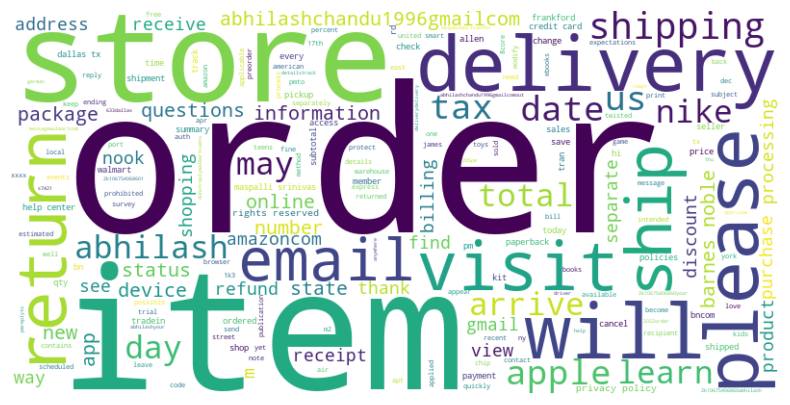

In [151]:
print("WordCloud for Email Text")
# Concatenate all the text from the "text_column" into a single string
text = " ".join(data_df["email_text"])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

<h2> 4.3 Word Cloud for - Email Subject </h2>

WordCloud for Email Subject


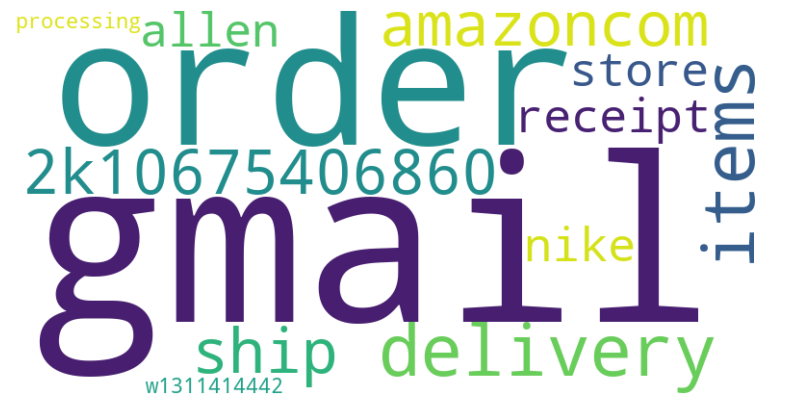

In [152]:
print("WordCloud for Email Subject")
# Concatenate all the text from the "text_column" into a single string
text = " ".join(data_df["email_subject"])

# Create a WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [153]:
data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6 entries, 0 to 5
Data columns (total 12 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   filename                 6 non-null      object
 1   email_text               6 non-null      object
 2   email_subject            6 non-null      object
 3   email_subject_length     6 non-null      int64 
 4   email_body_length        6 non-null      int64 
 5   class_label              6 non-null      int64 
 6   order_keyword            6 non-null      int64 
 7   shipping_keyword         6 non-null      int64 
 8   delivery_keyword         6 non-null      int64 
 9   email_text_length        6 non-null      int64 
 10  email_text_words         6 non-null      int64 
 11  email_text_unique_words  6 non-null      int64 
dtypes: int64(9), object(3)
memory usage: 704.0+ bytes


In [154]:
data_df

,filename,email_text,email_subject,email_subject_length,email_body_length,class_label,order_keyword,shipping_keyword,delivery_keyword,email_text_length,email_text_words,email_text_unique_words
0,shipping_update_walmart.html,gmail out for delivery items from order 2k106...,gmail out for delivery items from order 2k106...,56,1088,0,1,0,1,1145,253,111
1,shipping_update_amazon.html,gmail your amazoncom order 11437432531977031 ...,gmail your amazoncom order 11437432531977031 ...,57,1221,0,1,0,0,1279,198,132
2,eReceipt_Nike.html,gmail your receipt from nike store allenabhil...,gmail your receipt from nike store allen,41,1785,1,1,0,0,1827,290,200
3,shipping_update.html,billing summary for your recent barnes noble ...,,0,0,0,1,0,0,1007,178,126
4,eReceipt.html,barnes noble order confirmation 241300967 fin...,,0,0,1,1,1,1,2723,486,259
5,eReceipt_apple.html,gmail were processing your order w1311414442a...,gmail were processing your order w1311414442,45,2861,1,1,1,1,2907,495,280


In [155]:
data_df

,filename,email_text,email_subject,email_subject_length,email_body_length,class_label,order_keyword,shipping_keyword,delivery_keyword,email_text_length,email_text_words,email_text_unique_words
0,shipping_update_walmart.html,gmail out for delivery items from order 2k106...,gmail out for delivery items from order 2k106...,56,1088,0,1,0,1,1145,253,111
1,shipping_update_amazon.html,gmail your amazoncom order 11437432531977031 ...,gmail your amazoncom order 11437432531977031 ...,57,1221,0,1,0,0,1279,198,132
2,eReceipt_Nike.html,gmail your receipt from nike store allenabhil...,gmail your receipt from nike store allen,41,1785,1,1,0,0,1827,290,200
3,shipping_update.html,billing summary for your recent barnes noble ...,,0,0,0,1,0,0,1007,178,126
4,eReceipt.html,barnes noble order confirmation 241300967 fin...,,0,0,1,1,1,1,2723,486,259
5,eReceipt_apple.html,gmail were processing your order w1311414442a...,gmail were processing your order w1311414442,45,2861,1,1,1,1,2907,495,280


In [156]:

# Select the columns to be standardized
selected_numerical_columns = ["email_subject_length","email_body_length","email_text_length","email_text_words","email_text_unique_words"]

# Create a StandardScaler object
scaler = StandardScaler()

# Standardize the numerical columns
data_df[selected_numerical_columns] = scaler.fit_transform(data_df[selected_numerical_columns])

In [157]:
data_df.drop('email_subject',axis=1)

,filename,email_text,email_subject_length,email_body_length,class_label,order_keyword,shipping_keyword,delivery_keyword,email_text_length,email_text_words,email_text_unique_words
0,shipping_update_walmart.html,gmail out for delivery items from order 2k106...,0.946630,-0.071261,0,1,0,1,-0.888799,-0.496771,-1.108651
1,shipping_update_amazon.html,gmail your amazoncom order 11437432531977031 ...,0.988089,0.061915,0,1,0,0,-0.710951,-0.925919,-0.792610
2,eReceipt_Nike.html,gmail your receipt from nike store allenabhil...,0.324756,0.626663,1,1,0,0,0.016369,-0.208072,0.230760
3,shipping_update.html,billing summary for your recent barnes noble ...,-1.375032,-1.160703,0,1,0,0,-1.071956,-1.081973,-0.882907
4,eReceipt.html,barnes noble order confirmation 241300967 fin...,-1.375032,-1.160703,1,1,1,1,1.205564,1.321256,1.118684
5,eReceipt_apple.html,gmail were processing your order w1311414442a...,0.490589,1.704089,1,1,1,1,1.449773,1.391480,1.434724


In [158]:
df=data_df.drop(['email_subject','filename','email_text'],axis=1)

In [159]:
df

,email_subject_length,email_body_length,class_label,order_keyword,shipping_keyword,delivery_keyword,email_text_length,email_text_words,email_text_unique_words
0,0.946630,-0.071261,0,1,0,1,-0.888799,-0.496771,-1.108651
1,0.988089,0.061915,0,1,0,0,-0.710951,-0.925919,-0.792610
2,0.324756,0.626663,1,1,0,0,0.016369,-0.208072,0.230760
3,-1.375032,-1.160703,0,1,0,0,-1.071956,-1.081973,-0.882907
4,-1.375032,-1.160703,1,1,1,1,1.205564,1.321256,1.118684
5,0.490589,1.704089,1,1,1,1,1.449773,1.391480,1.434724


<h2> 1.7 TF-IDF * Weighted W2V - NLP </h2>

In [160]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
import gensim
from gensim.models import Word2Vec


# Step 1: Preprocess the text data (tokenization and removing punctuation)
# Your preprocessing steps here, e.g., using spaCy or other libraries

# Step 2: Calculate TF-IDF vectors
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectors = tfidf_vectorizer.fit_transform(data_df["email_text"])

# Step 3: Train Word2Vec model
sentences = [text.split() for text in data_df["email_text"]]
word2vec_model = Word2Vec(sentences, vector_size=100, window=5, min_count=1, workers=4)

# Step 4: Calculate TF-IDF weighted word vectors using Word2Vec embeddings
tfidf_weighted_word_vectors = []

for i in range(len(data_df)):
    sentence = data_df["email_text"][i].split()
    tfidf_weights = tfidf_vectors[i].toarray().flatten()
    
    weighted_word_vectors = [word2vec_model.wv[word] * weight for word, weight in zip(sentence, tfidf_weights)]
    tfidf_weighted_word_vector = sum(weighted_word_vectors) / sum(tfidf_weights)
    tfidf_weighted_word_vectors.append(tfidf_weighted_word_vector)

# Create new DataFrame with TF-IDF weighted word vectors
tfidf_weighted_word_vectors_df_email_text = pd.DataFrame(tfidf_weighted_word_vectors)

# Concatenate the original DataFrame with the TF-IDF weighted word vectors DataFrame
NLP_df = pd.concat([df, tfidf_weighted_word_vectors_df_email_text], axis=1)

In [161]:
NLP_df

,email_subject_length,email_body_length,class_label,order_keyword,shipping_keyword,delivery_keyword,email_text_length,email_text_words,email_text_unique_words,0,...,90,91,92,93,94,95,96,97,98,99
0,0.946630,-0.071261,0,1,0,1,-0.888799,-0.496771,-1.108651,0.000065,...,-0.000088,-0.000162,-0.000510,0.000034,0.000686,-0.000095,0.000202,-0.000332,-6.415909e-07,-0.000191
1,0.988089,0.061915,0,1,0,0,-0.710951,-0.925919,-0.792610,-0.000157,...,0.000193,0.000449,0.000136,-0.000267,0.000625,0.000476,0.000154,0.000114,1.342918e-04,-0.000017
2,0.324756,0.626663,1,1,0,0,0.016369,-0.208072,0.230760,-0.000453,...,0.000152,-0.000252,-0.000411,0.000065,0.000467,-0.000220,0.000132,-0.000546,5.188195e-04,-0.000829
3,-1.375032,-1.160703,0,1,0,0,-1.071956,-1.081973,-0.882907,-0.000301,...,0.000652,-0.000233,-0.000112,0.000187,0.000044,0.000536,0.000386,-0.000357,-1.182527e-04,-0.000164
4,-1.375032,-1.160703,1,1,1,1,1.205564,1.321256,1.118684,-0.000164,...,0.000856,0.000540,0.000650,-0.000034,0.002468,0.001166,0.000540,-0.000636,2.355312e-04,-0.000604
5,0.490589,1.704089,1,1,1,1,1.449773,1.391480,1.434724,-0.000395,...,0.000728,0.000410,-0.000203,-0.000477,0.001413,0.000267,0.000446,-0.000376,-3.878107e-05,-0.000141


In [162]:
# remove the first row 
#NLP_df.drop(data.index[0], inplace=True)
y_true = NLP_df['class_label']
NLP_df.drop(['class_label'], axis=1, inplace=True)

In [163]:
y_true

0    0
1    0
2    1
3    0
4    1
5    1
Name: class_label, dtype: int64

<h2> 1.8 Random train test split( 70:30) </h2>

In [165]:
X_train,X_test, y_train, y_test = train_test_split(NLP_df, y_true, stratify=y_true, test_size=0.3)

In [166]:
print("Number of data points in train data :",X_train.shape)
print("Number of data points in test data :",X_test.shape)

Number of data points in train data : (4, 108)
Number of data points in test data : (2, 108)


In [167]:
print("-"*10, "Distribution of output variable in train data", "-"*10)
train_distr = Counter(y_train)
train_len = len(y_train)
print("Class 0: ",int(train_distr[0])/train_len,"Class 1: ", int(train_distr[1])/train_len)
print("-"*10, "Distribution of output variable in train data", "-"*10)
test_distr = Counter(y_test)
test_len = len(y_test)
print("Class 0: ",int(test_distr[1])/test_len, "Class 1: ",int(test_distr[1])/test_len)

---------- Distribution of output variable in train data ----------
Class 0:  0.5 Class 1:  0.5
---------- Distribution of output variable in train data ----------
Class 0:  0.5 Class 1:  0.5


<h2> 1.9 Confusion matrix function </h2>

In [168]:
# This function plots the confusion matrices given y_i, y_i_hat.
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    # C = 9,9 matrix, each cell (i,j) represents number of points of class i are predicted class j
    
    A =(((C.T)/(C.sum(axis=1))).T)
    #divid each element of the confusion matrix with the sum of elements in that column
    
    # C = [[1, 2],
    #     [3, 4]]
    # C.T = [[1, 3],
    #        [2, 4]]
    # C.sum(axis = 1)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =1) = [[3, 7]]
    # ((C.T)/(C.sum(axis=1))) = [[1/3, 3/7]
    #                           [2/3, 4/7]]

    # ((C.T)/(C.sum(axis=1))).T = [[1/3, 2/3]
    #                           [3/7, 4/7]]
    # sum of row elements = 1
    
    B =(C/C.sum(axis=0))
    #divid each element of the confusion matrix with the sum of elements in that row
    # C = [[1, 2],
    #     [3, 4]]
    # C.sum(axis = 0)  axis=0 corresonds to columns and axis=1 corresponds to rows in two diamensional array
    # C.sum(axix =0) = [[4, 6]]
    # (C/C.sum(axis=0)) = [[1/4, 2/6],
    #                      [3/4, 4/6]] 
    plt.figure(figsize=(20,4))
    
    labels = [1,2]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

<h2> 2.0 Building a random model (Finding worst-case log-loss) </h2>

Log loss on Test Data using Random Model 1.581063743902101


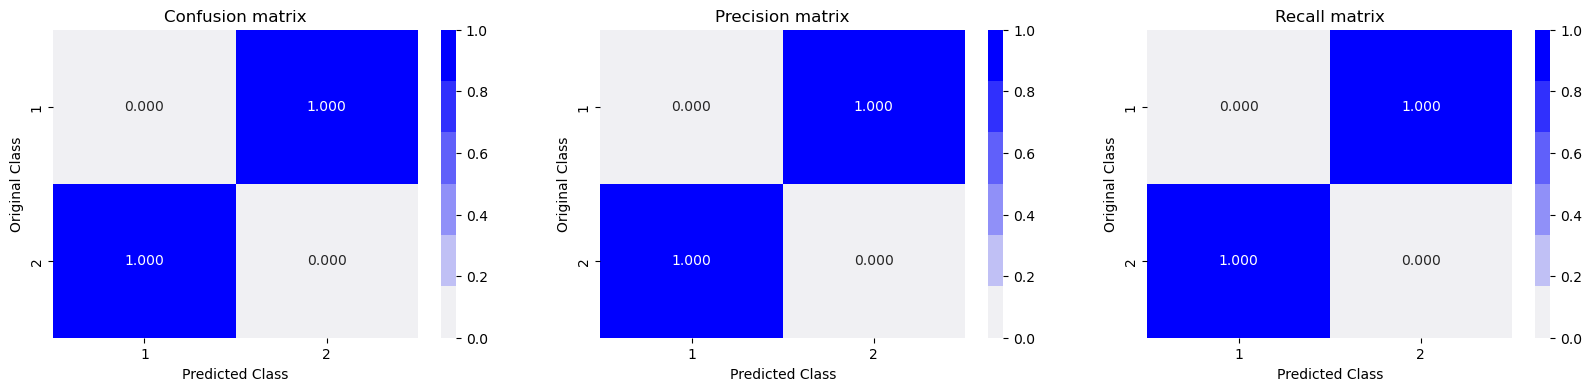

In [169]:
# we need to generate 9 numbers and the sum of numbers should be 1
# one solution is to genarate 9 numbers and divide each of the numbers by their sum
# ref: https://stackoverflow.com/a/18662466/4084039
# we create a output array that has exactly same size as the CV data
predicted_y = np.zeros((test_len,2))
for i in range(test_len):
    rand_probs = np.random.rand(1,2)
    predicted_y[i] = ((rand_probs/sum(sum(rand_probs)))[0])
print("Log loss on Test Data using Random Model",log_loss(y_test, predicted_y, eps=1e-15))

predicted_y =np.argmax(predicted_y, axis=1)
plot_confusion_matrix(y_test, predicted_y)

<h2> 2.1 Logistic Regression with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.2841763268818367
For values of alpha =  0.0001 The log loss is: 0.2966490061720748
For values of alpha =  0.001 The log loss is: 0.3503439705400143
For values of alpha =  0.01 The log loss is: 0.4297783441451681
For values of alpha =  0.1 The log loss is: 0.4641544567903078
For values of alpha =  1 The log loss is: 0.4810329741154349
For values of alpha =  10 The log loss is: 0.4936746123356548


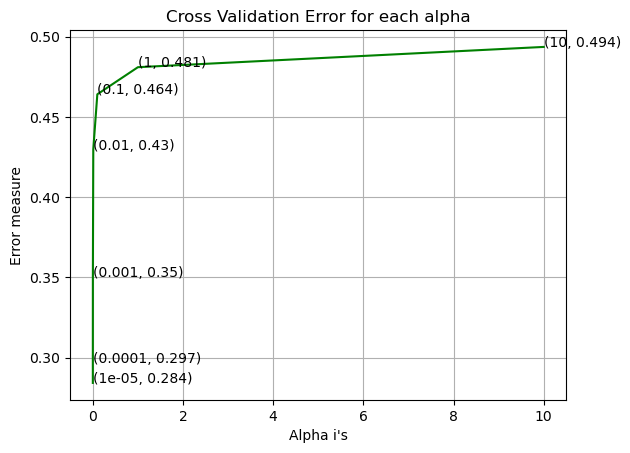

For values of best alpha =  1e-05 The train log loss is: 0.315314921602489
For values of best alpha =  1e-05 The test log loss is: 0.2841763268818367
Total number of data points : 2


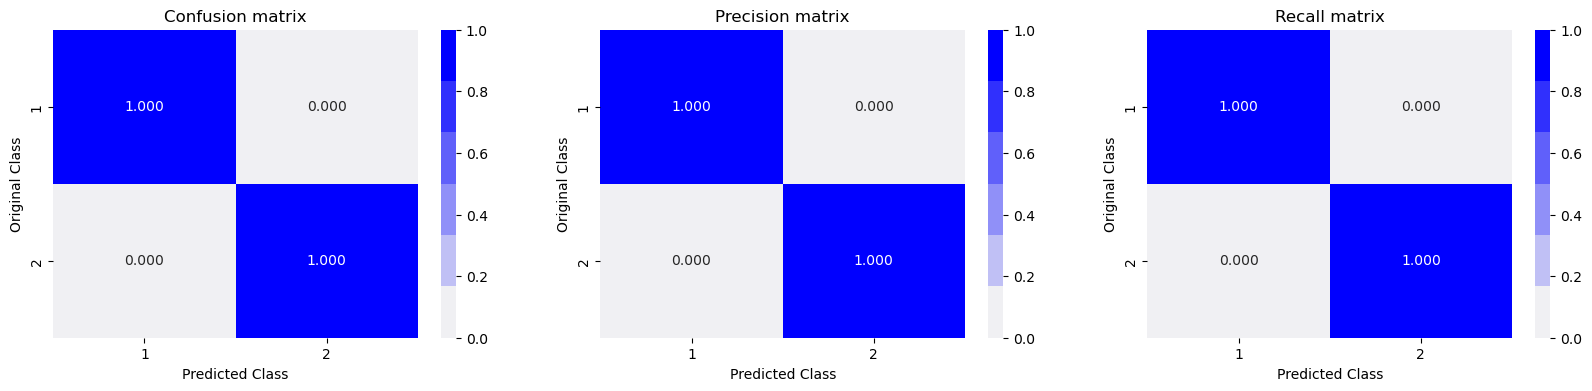

In [170]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l2', loss='log', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid",cv=2)
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l2', loss='log', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid",cv=2)
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 2.2 Linear SVM with hyperparameter tuning </h2>

For values of alpha =  1e-05 The log loss is: 0.29254782535282353
For values of alpha =  0.0001 The log loss is: 0.2926335787194045
For values of alpha =  0.001 The log loss is: 0.293428035801834
For values of alpha =  0.01 The log loss is: 0.2983793150494841
For values of alpha =  0.1 The log loss is: 0.5843638721737952
For values of alpha =  1 The log loss is: 0.4826953884812407
For values of alpha =  10 The log loss is: 0.6931471805599453


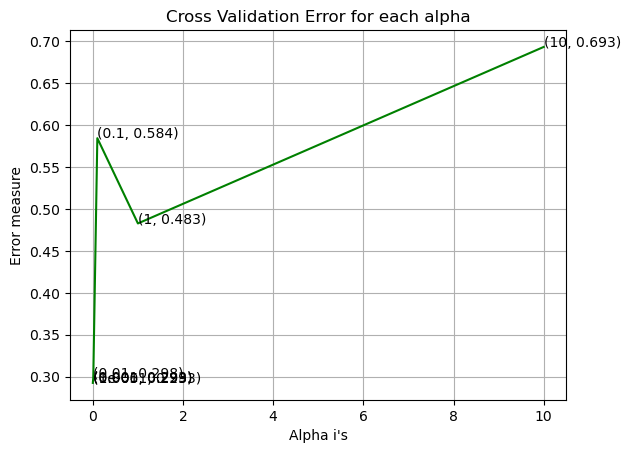

For values of best alpha =  1e-05 The train log loss is: 0.31352993184436534
For values of best alpha =  1e-05 The test log loss is: 0.29254782535282353
Total number of data points : 2


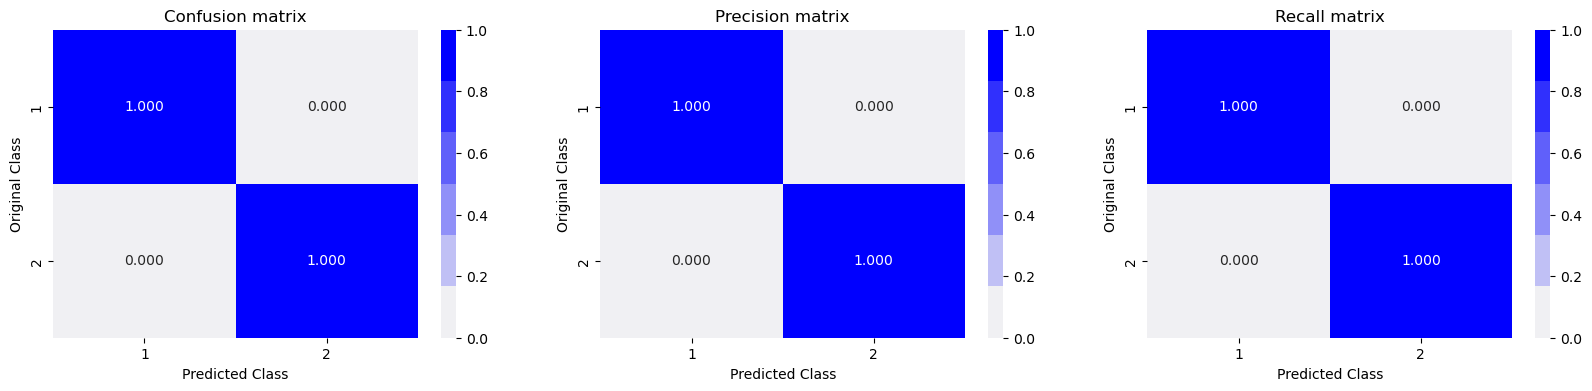

In [171]:
alpha = [10 ** x for x in range(-5, 2)] # hyperparam for SGD classifier.

# read more about SGDClassifier() at http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html
# ------------------------------
# default parameters
# SGDClassifier(loss=’hinge’, penalty=’l2’, alpha=0.0001, l1_ratio=0.15, fit_intercept=True, max_iter=None, tol=None, 
# shuffle=True, verbose=0, epsilon=0.1, n_jobs=1, random_state=None, learning_rate=’optimal’, eta0=0.0, power_t=0.5, 
# class_weight=None, warm_start=False, average=False, n_iter=None)

# some of methods
# fit(X, y[, coef_init, intercept_init, …])	Fit linear model with Stochastic Gradient Descent.
# predict(X)	Predict class labels for samples in X.

#-------------------------------
# video link: 
#------------------------------


log_error_array=[]
for i in alpha:
    clf = SGDClassifier(alpha=i, penalty='l1', loss='hinge', random_state=42)
    clf.fit(X_train, y_train)
    sig_clf = CalibratedClassifierCV(clf, method="sigmoid",cv=2)
    sig_clf.fit(X_train, y_train)
    predict_y = sig_clf.predict_proba(X_test)
    log_error_array.append(log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
    print('For values of alpha = ', i, "The log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

fig, ax = plt.subplots()
ax.plot(alpha, log_error_array,c='g')
for i, txt in enumerate(np.round(log_error_array,3)):
    ax.annotate((alpha[i],np.round(txt,3)), (alpha[i],log_error_array[i]))
plt.grid()
plt.title("Cross Validation Error for each alpha")
plt.xlabel("Alpha i's")
plt.ylabel("Error measure")
plt.show()


best_alpha = np.argmin(log_error_array)
clf = SGDClassifier(alpha=alpha[best_alpha], penalty='l1', loss='hinge', random_state=42)
clf.fit(X_train, y_train)
sig_clf = CalibratedClassifierCV(clf, method="sigmoid",)
sig_clf.fit(X_train, y_train)

predict_y = sig_clf.predict_proba(X_train)
print('For values of best alpha = ', alpha[best_alpha], "The train log loss is:",log_loss(y_train, predict_y, labels=clf.classes_, eps=1e-15))
predict_y = sig_clf.predict_proba(X_test)
print('For values of best alpha = ', alpha[best_alpha], "The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))
predicted_y =np.argmax(predict_y,axis=1)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

<h2> 2.3 XGBoost </h2>

In [177]:
# import xgboost as xgb
params = {}
params['objective'] = 'binary:logistic'
params['eval_metric'] = 'logloss'
params['eta'] = 0.02
params['max_depth'] = 4

d_train = xgb.DMatrix(X_train, label=y_train)
d_test = xgb.DMatrix(X_test, label=y_test)

watchlist = [(d_train, 'train'), (d_test, 'valid')]

bst = xgb.train(params, d_train, 400, watchlist, early_stopping_rounds=20, verbose_eval=10)

xgdmat = xgb.DMatrix(X_train,y_train)
predict_y = bst.predict(d_test)
print("The test log loss is:",log_loss(y_test, predict_y, labels=clf.classes_, eps=1e-15))

[0]	train-logloss:0.69315	valid-logloss:0.69315
[10]	train-logloss:0.69315	valid-logloss:0.69315
[19]	train-logloss:0.69315	valid-logloss:0.69315
The test log loss is: 0.6931471824645996


Total number of data points : 2


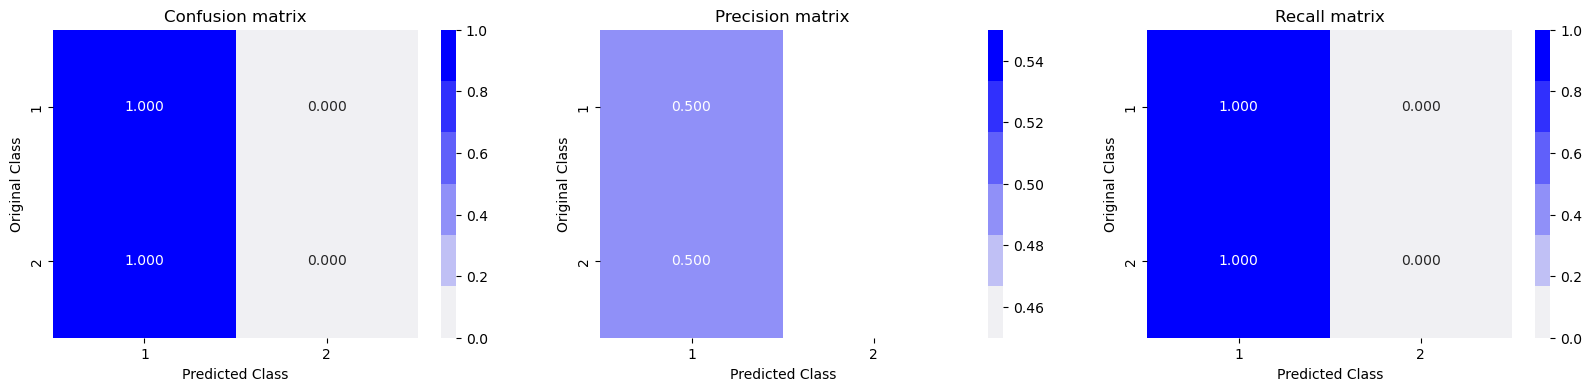

In [178]:
predicted_y =np.array(predict_y>0.5,dtype=int)
print("Total number of data points :", len(predicted_y))
plot_confusion_matrix(y_test, predicted_y)

In [187]:

from prettytable import PrettyTable
  
# Specify the Column Names while initializing the Table
myTable = PrettyTable(["Model Name", "Train Log Loss","Test Log Loss"])
  
# Add rows
myTable.add_row(["Random Model", "1.58","1.58"])
myTable.add_row(["Logistic Regression", "0.31","0.28" ])
myTable.add_row(["Linear SVM", "0.31","0.29"])
myTable.add_row(["XGBoost", "0.69","0.69"])
  
print(myTable)

+---------------------+----------------+---------------+
|      Model Name     | Train Log Loss | Test Log Loss |
+---------------------+----------------+---------------+
|     Random Model    |      1.58      |      1.58     |
| Logistic Regression |      0.31      |      0.28     |
|      Linear SVM     |      0.31      |      0.29     |
|       XGBoost       |      0.69      |      0.69     |
+---------------------+----------------+---------------+
